# Processing Data


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ruff: noqa: E402
# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl
import dotenv


ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))


dotenv.load_dotenv(ROOT.joinpath(".env"))

from src.utils import check_gpu_available

GPU = check_gpu_available()
print(f"GPU available: {GPU}")

GPU available: False


## Load the Network


In [3]:
import geopandas as gpd
from src.geometry import RoadNetwork


mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
    step_size=0.01,
)

full_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=None,
    step_size=0.01,
)

LANE_WIDTH = 3.55
LANE_NUM = 2

## Read in the Trajectories


In [4]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df


USE_FRONT = False


radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "march_calibrated.yaml",
)

In [5]:
radar_df = (
    pl.scan_parquet(
        # Path(os.environ.get("RAW_DATA_DIR")).joinpath("*.parquet")
        # Path("/home/max/Development/ua-traffic-data/tmp/all_working.parquet")
        "/Users/max/Development/DOE-Project/ua-traffic-data/tmp/all_working_processed.parquet"
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC").dt.round("100ms"),
    )
    # .filter(
    #     pl.col("epoch_time").dt.month().is_in([3])
    #     & pl.col("epoch_time").dt.day().is_in([30, 31])
    #     # & pl.col("epoch_time").dt.hour().is_in([9, 10])
    # )
    .pipe(prep_df, f=radar_obj)
    .filter(
        pl.col("epoch_time_cst").is_between(
            pl.lit("2023-03-13 07:40:54").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
            pl.lit("2023-03-13 08:46:00").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
        )
        # & (pl.col("lane").str.contains("W"))
        # & (pl.col("lane_index") == 0)
    )
    .collect(streaming=True)
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=LANE_WIDTH * LANE_NUM
        - (LANE_WIDTH / 2)
        + 0.5,  # centered on one of the lanes,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .rename(
        {
            "name": "lane",
            "angle": "heading_lane",
        }
    )
)

function: create_object_id took: 0.018249988555908203 seconds
function: filter_short_trajectories took: 0.008219242095947266 seconds
function: clip_trajectory_end took: 0.0017657279968261719 seconds
function: resample took: 0.005566835403442383 seconds
function: fix_duplicate_positions took: 0.0004420280456542969 seconds
function: set_timezone took: 9.584426879882812e-05 seconds
function: add_cst_timezone took: 5.5789947509765625e-05 seconds
function: add_heading took: 0.0007960796356201172 seconds
function: rotate_radars took: 0.0013911724090576172 seconds
function: update_origin took: 0.0005488395690917969 seconds


ComputeError: TypeError: 'module' object does not support item assignment

In [ ]:
radar_df.head()

shape: (5, 41)
┌───────────┬────────────┬────────────┬────────────┬───┬──────────┬────────────┬────────────┬──────┐
│ object_id ┆ epoch_time ┆ f32_trackQ ┆ f32_positi ┆ … ┆ y_lane   ┆ s          ┆ heading_la ┆ lane │
│ ---       ┆ ---        ┆ uality     ┆ onX_m      ┆   ┆ ---      ┆ ---        ┆ ne         ┆ ---  │
│ i64       ┆ datetime[m ┆ ---        ┆ ---        ┆   ┆ f64      ┆ f64        ┆ ---        ┆ str  │
│           ┆ s, UTC]    ┆ f32        ┆ f32        ┆   ┆          ┆            ┆ f64        ┆      │
╞═══════════╪════════════╪════════════╪════════════╪═══╪══════════╪════════════╪════════════╪══════╡
│ 14479     ┆ 2023-03-13 ┆ 39.032669  ┆ 17.038435  ┆ … ┆ null     ┆ null       ┆ null       ┆ null │
│           ┆ 12:40:54   ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
│           ┆ UTC        ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
│ 14663     ┆ 2023-03-13 ┆ 77.70031   ┆ 25.384138  ┆ … ┆ null     ┆ null       ┆ null       ┆ null │
│           ┆ 12:40:54   ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
│           ┆ UTC        ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
│ 14730     ┆ 2023-03-13 ┆ 79.497734  ┆ 19.260685  ┆ … ┆ null     ┆ null       ┆ null       ┆ null │
│           ┆ 12:40:54   ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
│           ┆ UTC        ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
│ 14732     ┆ 2023-03-13 ┆ 76.178795  ┆ 14.100366  ┆ … ┆ 3.6774e6 ┆ 466.849143 ┆ 0.262035   ┆ EBL1 │
│           ┆ 12:40:54   ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
│           ┆ UTC        ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
│ 14784     ┆ 2023-03-13 ┆ 53.401413  ┆ 19.147522  ┆ … ┆ null     ┆ null       ┆ null       ┆ null │
│           ┆ 12:40:54   ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
│           ┆ UTC        ┆            ┆            ┆   ┆          ┆            ┆            ┆      │
└───────────┴────────────┴────────────┴────────────┴───┴──────────┴────────────┴────────────┴──────┘

In [ ]:
radar_df.lazy().group_by("object_id").agg(
    (pl.col("f32_positionX_m").diff() ** 2 + pl.col("f32_positionY_m").diff() ** 2)
    .sqrt()
    .sum()
    .alias("distance")
).select(pl.col("distance").mean()).collect()

shape: (1, 1)
┌────────────┐
│ distance   │
│ ---        │
│ f32        │
╞════════════╡
│ 154.791611 │
└────────────┘

In [ ]:
radar_df.with_columns(pl.count().over(["epoch_time", "object_id"])).filter(
    pl.col("count") > 1
).sort(["epoch_time", "object_id"]).select(["epoch_time", "object_id", "count"])

shape: (0, 3)
┌───────────────────┬───────────┬───────┐
│ epoch_time        ┆ object_id ┆ count │
│ ---               ┆ ---       ┆ ---   │
│ datetime[ms, UTC] ┆ i64       ┆ u32   │
╞═══════════════════╪═══════════╪═══════╡
└───────────────────┴───────────┴───────┘

In [ ]:
from src.pipelines.kalman_filter import (
    prepare_frenet_measurement,
    build_extension,
    add_timedelta,
    build_kalman_id,
    filter_short_trajectories,
)


prediction_length = 3.5

print(radar_df.shape)

radar_df = (
    radar_df.pipe(add_timedelta, vehicle_id_col=["object_id", "lane"])
    .pipe(build_kalman_id, split_time_delta=prediction_length + 0.1)
    .pipe(filter_short_trajectories, minimum_distance_m=5, minimum_duration_s=2)
    .pipe(prepare_frenet_measurement)
    .pipe(build_extension, seconds=prediction_length)
    .pipe(add_timedelta)
    .collect()
)

print(radar_df.shape)

(1777142, 41)
function: add_timedelta took: 0.0015380382537841797 seconds
function: build_kalman_id took: 0.014748811721801758 seconds
function: filter_short_trajectories took: 0.003818988800048828 seconds
function: prepare_frenet_measurement took: 0.03855085372924805 seconds
function: build_extension took: 16.758660078048706 seconds
function: add_timedelta took: 0.020442962646484375 seconds
(1575718, 55)


<Axes: xlabel='dist', ylabel='f32_length_m'>

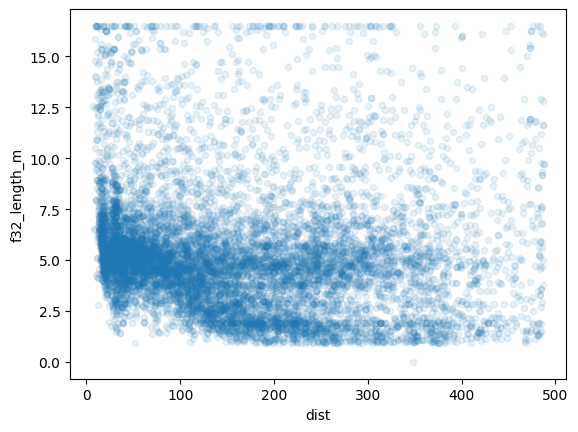

In [ ]:
radar_df[["dist", "f32_length_m"]].sample(10_000).to_pandas().plot.scatter(
    x="dist", y="f32_length_m", alpha=0.1
)

<Axes: ylabel='Frequency'>

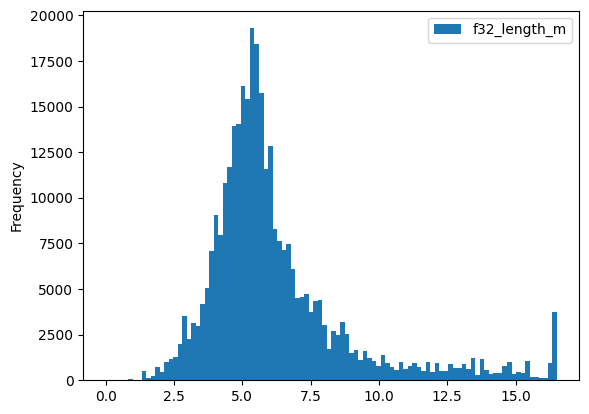

In [ ]:
radar_df.filter(pl.col("dist").is_between(10, 50))[
    ["f32_length_m"]
].to_pandas().plot.hist(bins=100)

In [ ]:
from src.pipelines.kalman_filter import build_kalman_df

filter_df = (
    radar_df
    # .with_columns((pl.col("distanceToFront_s") + pl.col("s")).alias("front_s"))
    .pipe(build_kalman_df, s_col="front_s" if USE_FRONT else "s")
    .filter(
        pl.col("max_time") < pl.col("max_time").max()  # filter out the outlier times
    )
    .collect()
)

function: build_kalman_df took: 0.023115873336791992 seconds


### IMM Filter the Radar Trajectories


In [ ]:
filter_df.group_by("vehicle_ind").agg(pl.col("time_ind").max())["time_ind"].describe(
    percentiles=[0.5, 0.75, 0.9, 0.95, 0.9999]
)

shape: (11, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 10489.0    │
│ null_count ┆ 0.0        │
│ mean       ┆ 149.144246 │
│ std        ┆ 81.169447  │
│ …          ┆ …          │
│ 90%        ┆ 230.0      │
│ 95%        ┆ 277.0      │
│ 100%       ┆ 731.0      │
│ max        ┆ 786.0      │
└────────────┴────────────┘

In [ ]:
from src.filters.vectorized_kalman import batch_imm_df
import numpy as np

filt_df = batch_imm_df(
    filter_df.rename({"measurement": "z"}),
    filters=("CALC", "CALK", "CVLK"),
    M=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
    mu=np.array([0.2, 0.2, 0.6]),
    # chunk_size=3_500,
    chunk_size=100_000 if not GPU else 9_000 * 1000,
    gpu=GPU,
)

100%|██████████| 17/17 [00:22<00:00,  1.31s/it]


In [ ]:
from src.pipelines.kalman_filter import join_results

joined_df = join_results(filt_df, filter_df, radar_df)

if USE_FRONT:
    joined_df = joined_df.rename({"s": "front_s"})

joined_df = joined_df.collect(streaming=True)

function: join_results took: 0.0029523372650146484 seconds


In [ ]:
print(
    "{:3d},{:3d},{:3d}".format(
        joined_df.shape[0], filter_df.shape[0], radar_df.shape[0]
    )
)

1574863,1574863,1575718


In [ ]:
radar_df.with_columns(pl.count().over(["epoch_time", "object_id"])).filter(
    pl.col("count") > 1
).sort(["epoch_time", "object_id"]).select(["epoch_time", "object_id", "count"])

shape: (0, 3)
┌───────────────────┬───────────┬───────┐
│ epoch_time        ┆ object_id ┆ count │
│ ---               ┆ ---       ┆ ---   │
│ datetime[ms, UTC] ┆ i64       ┆ u32   │
╞═══════════════════╪═══════════╪═══════╡
└───────────────────┴───────────┴───────┘

In [ ]:
joined_df.with_columns(pl.count().over(["epoch_time", "object_id"])).filter(
    pl.col("count") > 1
).sort(["epoch_time", "object_id"]).select(["epoch_time", "object_id", "count"])

shape: (0, 3)
┌───────────────────┬───────────┬───────┐
│ epoch_time        ┆ object_id ┆ count │
│ ---               ┆ ---       ┆ ---   │
│ datetime[ms, UTC] ┆ i64       ┆ u32   │
╞═══════════════════╪═══════════╪═══════╡
└───────────────────┴───────────┴───────┘

In [ ]:
if "joined_df" not in locals():
    joined_df = pl.read_parquet(
        Path(os.environ.get("RAW_DATA_DIR"))
        / "march_kalman_filter_results"
        / "*/*.parquet",
        use_pyarrow=True,
        memory_map=True,
    )

In [ ]:
joined_df = joined_df.lazy().sort("epoch_time").collect(streaming=True).rechunk()

## Plotting the Lanes


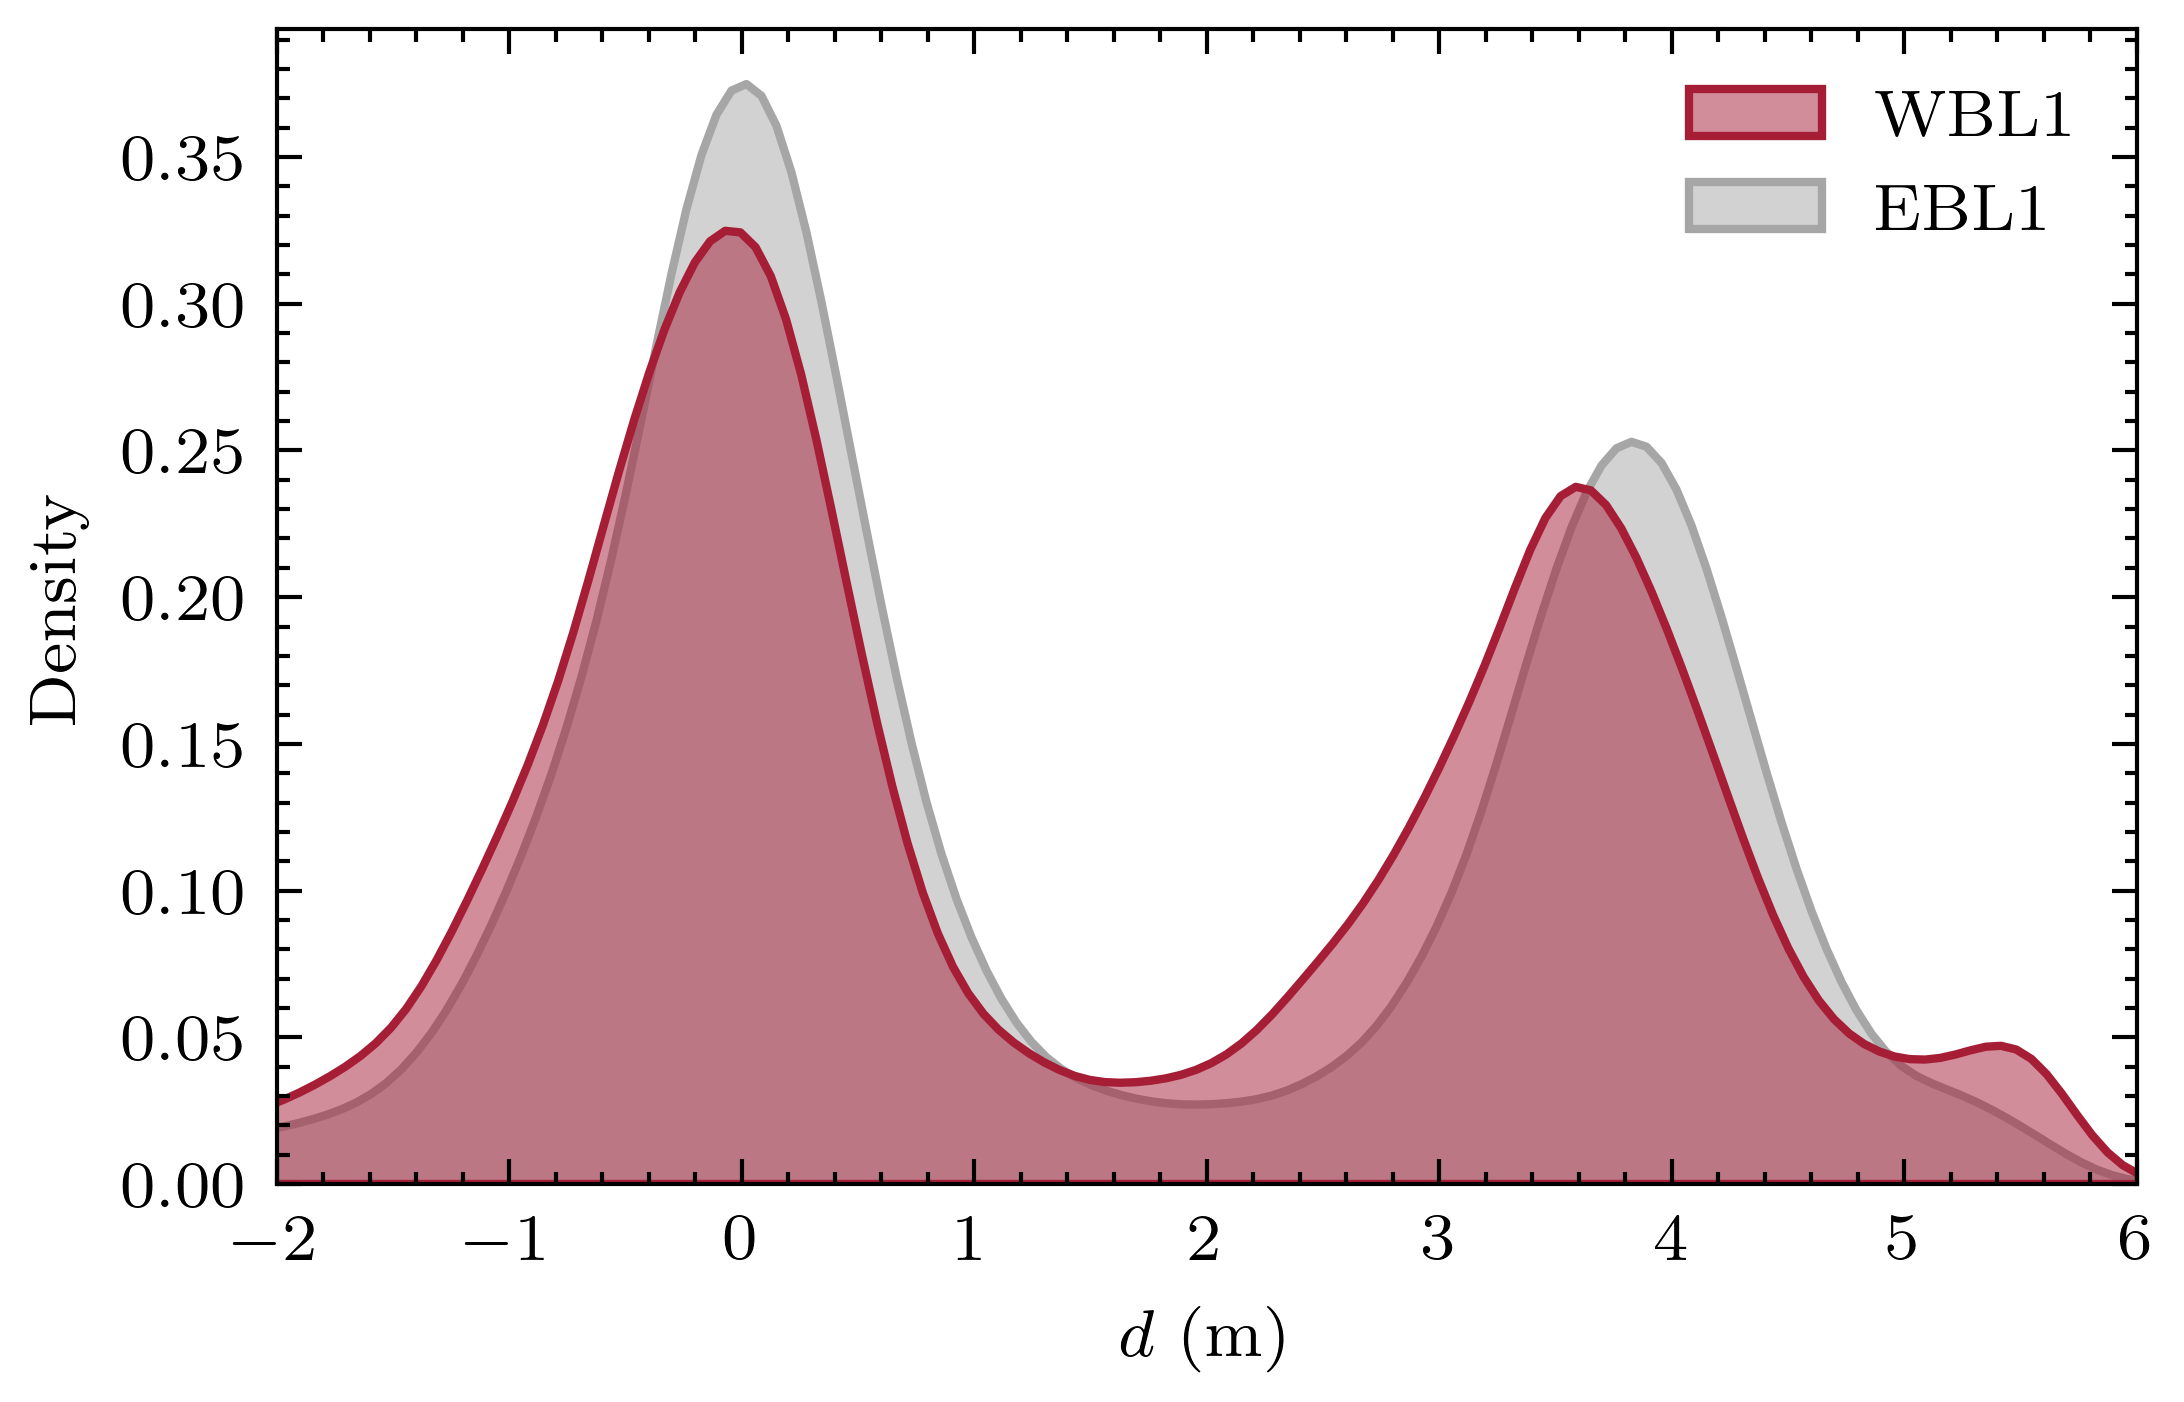

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

engine_color = [0.65, 0.65, 0.65]
gps_color = [0, 0, 0.75]
plutron_color = [0, 0, 0]
alabama = [165, 30, 54]
alabama = [i / 255 for i in alabama]

plt.style.use(["science", "ieee"])

fig, ax = plt.subplots(
    figsize=(4, 2.5),
)

# joined_df.filter(pl.col("lane").str.contains("E") & pl.col("d").is_between(-6, 6))[
#     ["d"]
# ].sample(100_000).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5, )

# create a kde plot of the d dimension in both directions
lane_df = (
    joined_df.select(
        [
            "lane",
            "d",
        ]
    )
    .melt(id_vars="lane", value_name="d")
    .filter(pl.col("d").is_between(-6, 6))
    .sample(1_000_000)
)


lane_df = lane_df.to_pandas()

sns.kdeplot(
    data=lane_df,
    x="d",
    hue="lane",
    fill=True,
    common_norm=False,
    alpha=0.5,
    ax=ax,
    linewidth=1,
    palette=[alabama, engine_color],
)

ax.set_xlim(-2, 6)

ax.set_xlabel("$d$ (m)")
# remove the title of the legend
ax.get_legend().set_title("")

# st th

### Classify the Lanes


In [ ]:
from src.pipelines.lane_classification import label_lane, label_lanes_tree
from src.gmm.lane_classification import build_lane_model
from src.plotting.lane_gmm import plot_model

In [ ]:
joined_df = joined_df.pipe(
    label_lanes_tree,
    full_network=full_net,
    kalman_network=mainline_net,
    lane_width=LANE_WIDTH,
    s_col="front_s" if USE_FRONT else "s",
)


print(joined_df.filter(pl.col("lane_index").is_null()).shape[0] / joined_df.shape[0])

joined_df = joined_df.with_columns(pl.col("lane_index").fill_null(2))

0.07128429584033659


/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_86728/3649221666.py:22: UserWarning: 
The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(


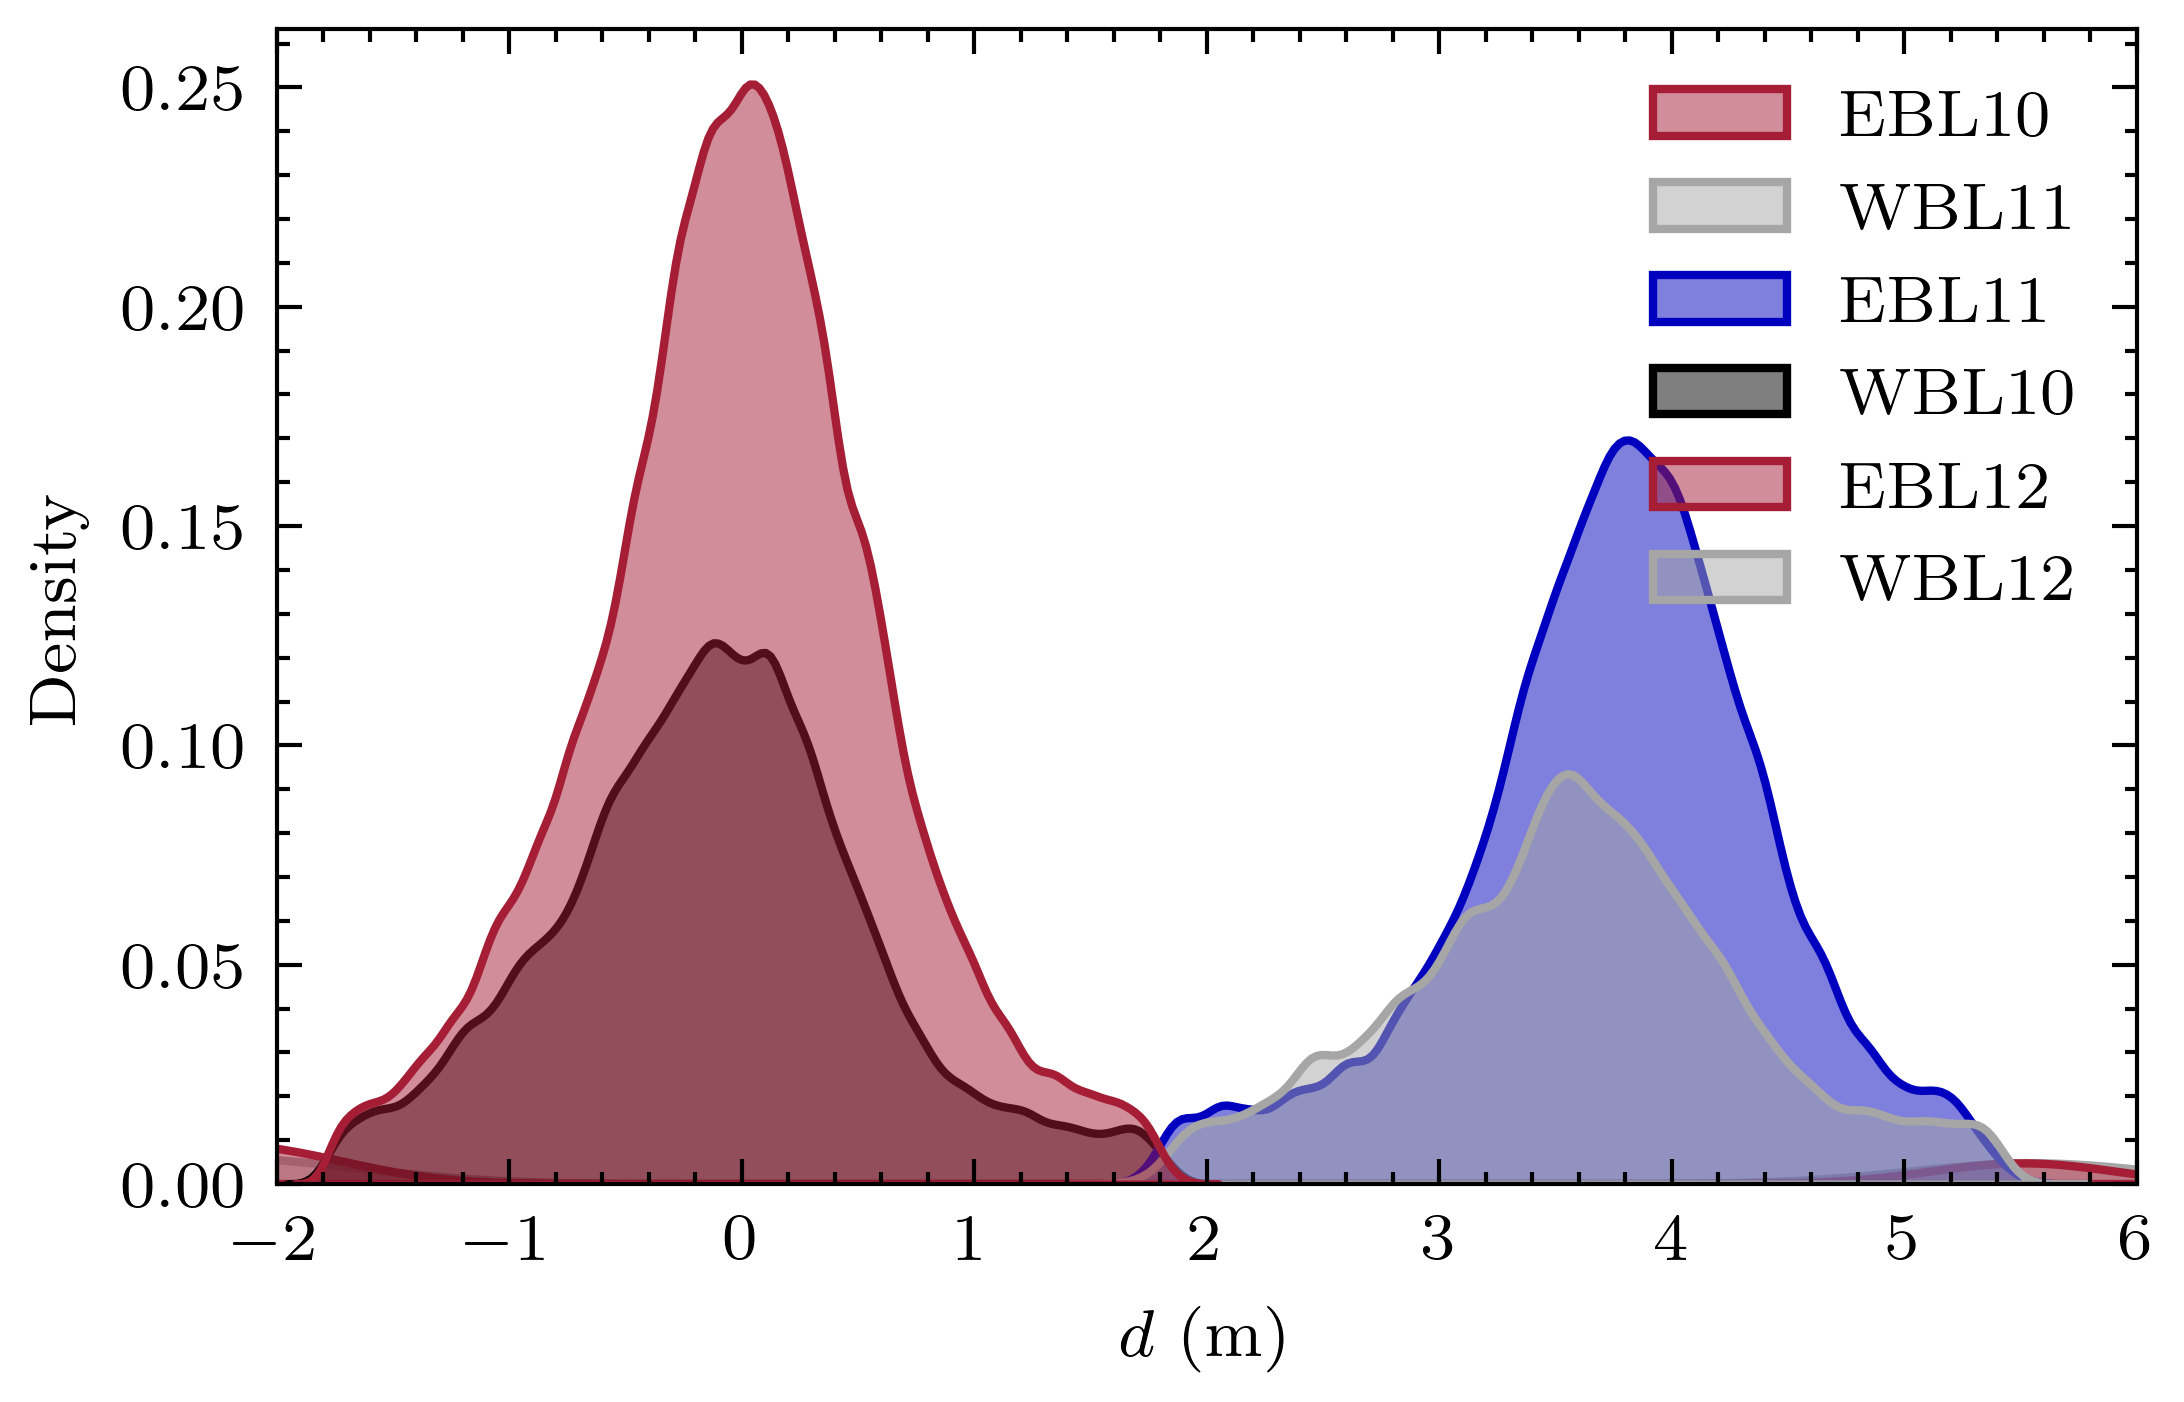

In [ ]:
fig, ax = plt.subplots(
    figsize=(4, 2.5),
)

lane_df = (
    joined_df.select(
        [
            pl.concat_str([pl.col("lane"), pl.col("lane_index").cast(str)]).alias(
                "lane"
            ),
            "d",
        ]
    )
    .melt(id_vars="lane", value_name="d")
    .filter(pl.col("d").is_between(-6, 6))
    .sample(1_000_000)
)


lane_df = lane_df.to_pandas()

sns.kdeplot(
    data=lane_df,
    x="d",
    hue="lane",
    fill=True,
    common_norm=True,
    alpha=0.5,
    ax=ax,
    linewidth=1,
    palette=[alabama, engine_color, gps_color, plutron_color],
)

ax.set_xlim(-2, 6)

ax.set_xlabel("$d$ (m)")
# remove the title of the legend
ax.get_legend().set_title("")

# st th

## Save the Kalman Filtered Trajectories


## Merge the Trajectories


#### Things to try:

1. Ignore sublanes
2. Can you do x/y instead of s/d?
3.


In [ ]:
from src.pipelines.association import (
    build_leader_follower_df,
    add_front_back_s,
    build_leader_follower_entire_history_df,
)

joined_df = (
    joined_df.lazy()
    .pipe(
        add_front_back_s,
        use_global_median=True,
    )
    .sort(by=["epoch_time"])
    .set_sorted(["epoch_time"])
    .collect(streaming=True)
)

function: add_front_back_s took: 0.36116790771484375 seconds


In [ ]:
lf_df = (
    joined_df.lazy()
    .pipe(
        build_leader_follower_entire_history_df,
        s_col="front_s" if USE_FRONT else "s",
        use_lane_index=True,
        max_s_gap=0.5 * 25,  # max headway of 0.5 seconds at 25 m/s
    )
    .filter(~(pl.col("prediction") & pl.col("prediction_leader")))
    .filter(pl.col("lane_index") <= 1)
    .collect(streaming=True)
)

function: lazy_func took: 0.009319067001342773 seconds


### Calculate the Association Log-Likelihood Distance


In [ ]:
from src.pipelines.association import calc_assoc_liklihood_distance

dims = 4

lf_df = lf_df.pipe(calc_assoc_liklihood_distance, gpu=True, dims=dims, permute=True)

function: lazy_func took: 88.1952121257782 seconds


### Calculate the Match Indexes


In [ ]:
from scipy.stats import chi2
from src.pipelines.association import (
    calculate_match_indexes,
    pipe_gate_headway_calc,
    build_match_df,
    filter_bad_lane_matches,
)

# prediction_length = 4

assoc1_df = (
    lf_df
    # is this really necessary? Just filters the match for a certain tome
    .pipe(calculate_match_indexes, match_time_threshold=100, min_time_threshold=1)
    .pipe(
        pipe_gate_headway_calc,
        alpha=0.1,
        window=20,
        association_dist_cutoff=chi2.ppf(0.9875, dims),
    )
    .collect(streaming=True)
)

function: lazy_func took: 0.009666204452514648 seconds
function: lazy_func took: 0.057581186294555664 seconds


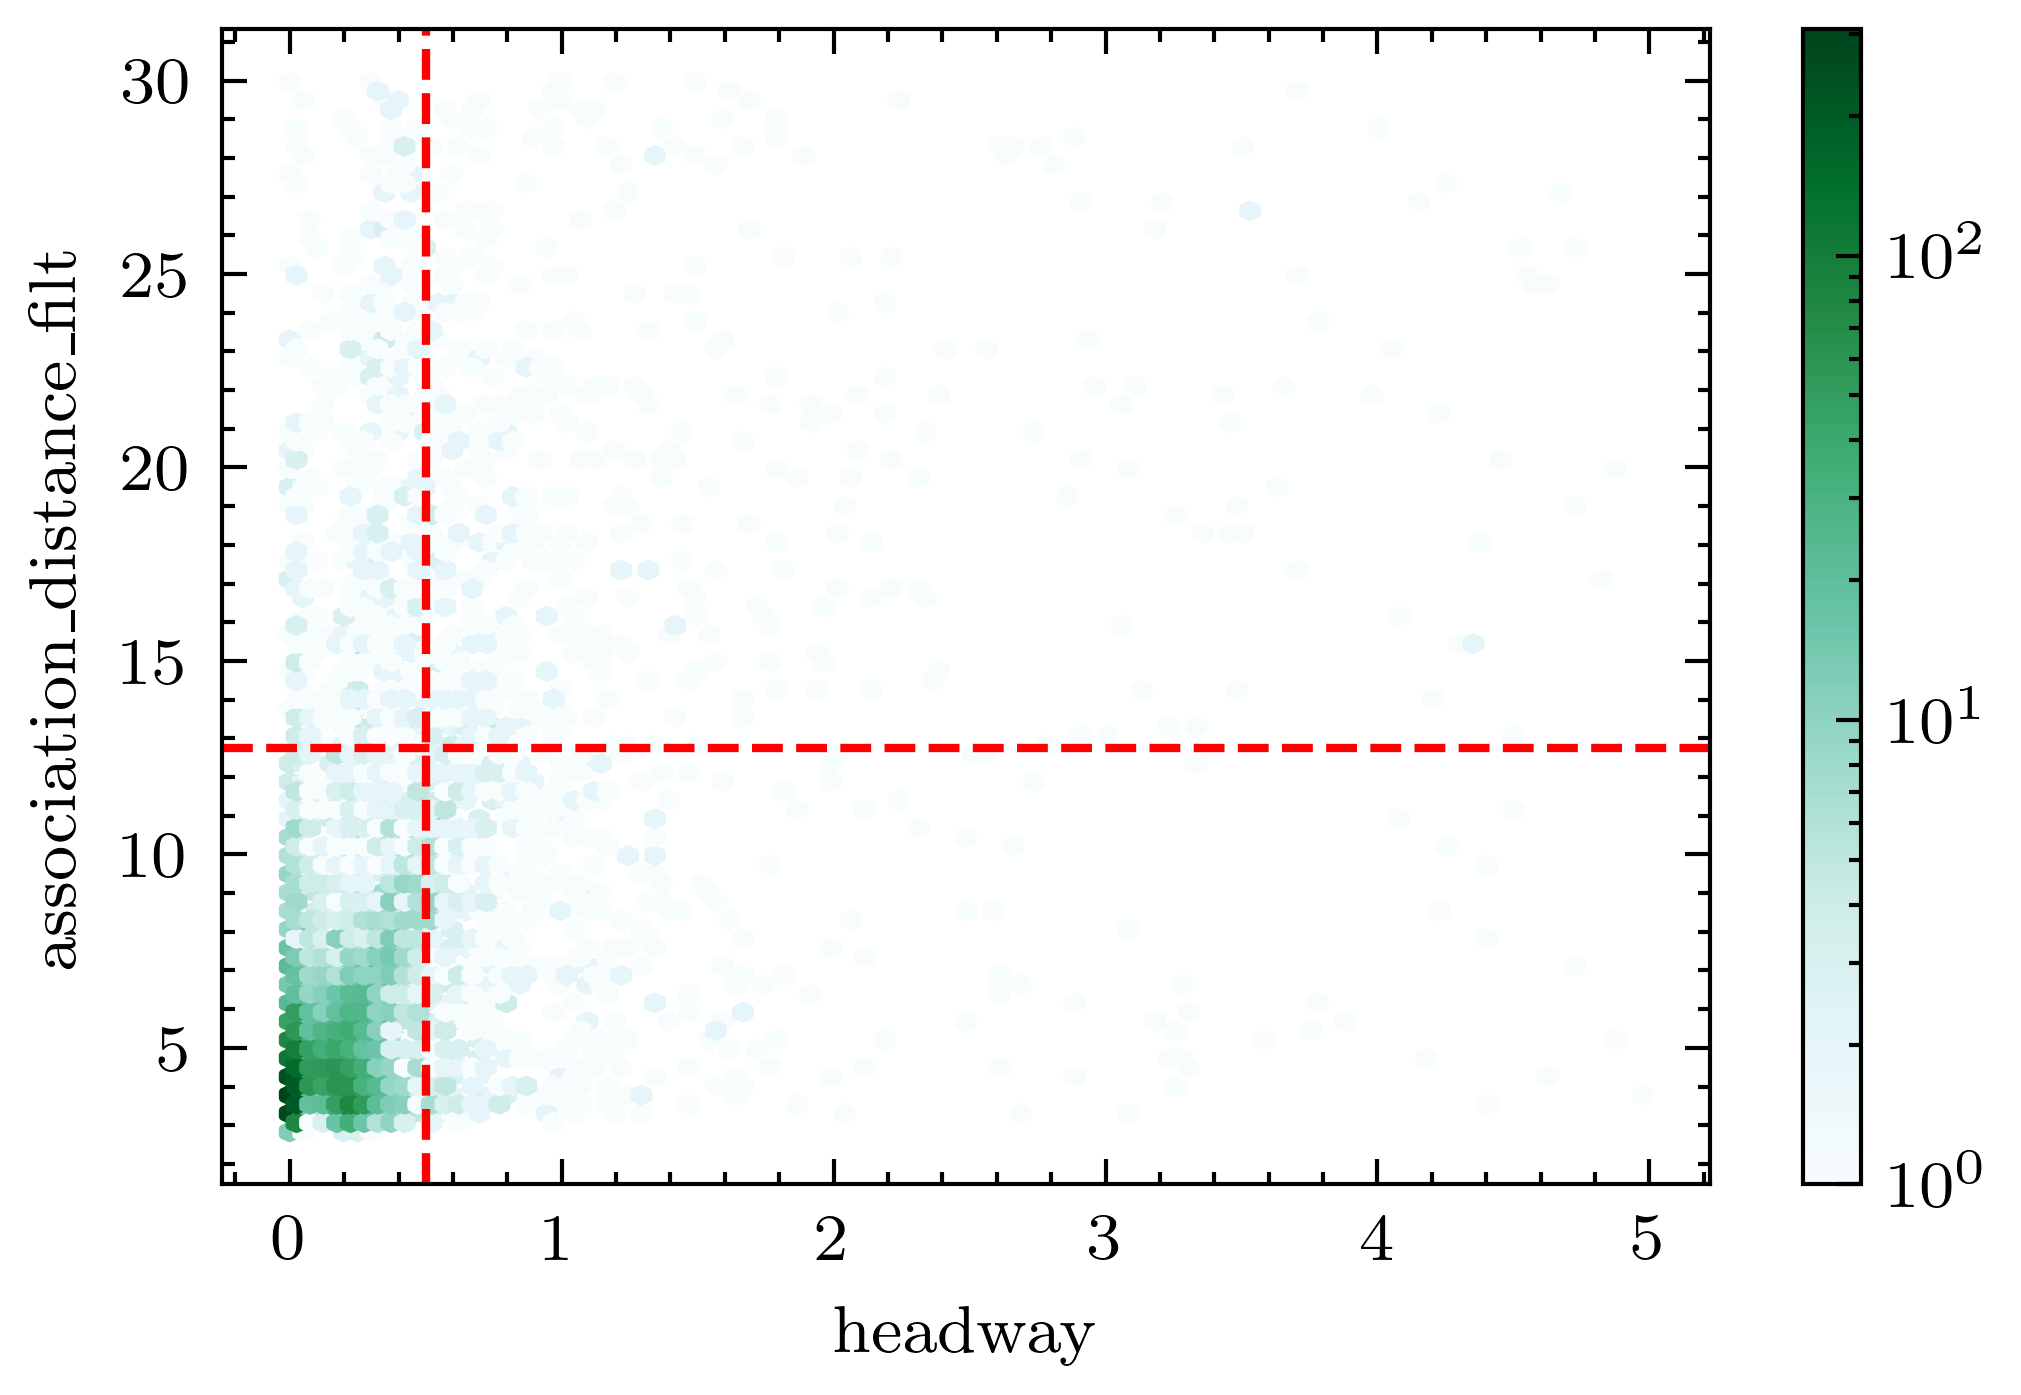

In [ ]:
# # scatter plot the association distance vs the headway
# fig, ax = plt.subplots(figsize=(4, 2.5))

# assoc1_df.filter(pl.col("headway").is_between(-10, 20))[
#     ["headway", "association_distance_filt"]
# ].sample(10_000).to_pandas().plot.contour(x="headway", y="association_distance_filt", alpha=0.01, ax=ax)


# make a contour plot of the association distance vs the headway
import matplotlib


fig, ax = plt.subplots(figsize=(4, 2.5))

assoc1_df.filter(
    pl.col("headway").is_between(0, 5)
    & pl.col("association_distance_filt").is_between(-5, 30)
)[["headway", "association_distance_filt"]].to_pandas().plot.hexbin(
    x="headway",
    y="association_distance_filt",
    ax=ax,
    gridsize=100,
    norm=matplotlib.colors.LogNorm(),
)


# add a horizontal line at the 95th percentile of the chi squared distribution
ax.axhline(chi2.ppf(0.9875, dims), color="r", linestyle="--")

# # set the y axis range
# ax.set_ylim(-5, 10)

# add a vertical line at headway cutoff of 0.5
ax.axvline(0.5, color="r", linestyle="--")

In [ ]:
match_df = (
    assoc1_df.lazy()
    .pipe(
        build_match_df,
        traj_time_df=joined_df.group_by("object_id")
        .agg(
            pl.col("epoch_time").max().alias("epoch_time_max"),
        )
        .lazy(),
        assoc_cutoff=chi2.ppf(0.95, dims),
        assoc_cutoff_pred=chi2.ppf(0.95, dims),
        time_headway_cutoff=0.01,
    )
    .collect(streaming=True)
)


# 1 - 0.99

function: lazy_func took: 0.09141707420349121 seconds


### Re-Label the Joined Trajectories


In [ ]:
from src.pipelines.association import create_vehicle_ids
import networkx as nx
from itertools import combinations
from networkx.algorithms.connectivity import (
    node_connectivity,
    all_pairs_node_connectivity,
)

cc, G, assoc_df = joined_df.pipe(
    create_vehicle_ids,
    match_df,
)


def get_ordered_combinations(cc_list):
    return [
        (start, end, veh_i) if start < end else (end, start, veh_i)
        for veh_i, cc_list in enumerate(cc)
        for start, end in combinations(cc_list, 2)
    ]

function: lazy_func took: 0.18076419830322266 seconds


In [ ]:
begin_end_df = joined_df.group_by("object_id").agg(
    pl.col("epoch_time").min().alias("begin_time"),
    pl.col("epoch_time").max().alias("end_time"),
)

combs = get_ordered_combinations(cc)

permute_df = (
    pl.DataFrame(
        combs,
        schema=["start", "end", "vehicle_index"],
    )
    .join(
        begin_end_df.rename({"object_id": "start"}).with_columns(
            pl.col("start").cast(int)
        ),
        on="start",
    )
    .join(
        begin_end_df.rename({"object_id": "end"}).with_columns(pl.col("end").cast(int)),
        on="end",
    )
    .with_columns(
        pl.col(["start", "end"]).cast(pl.UInt32),
    )
    # filter for overlap in time
    .filter(
        pl.min_horizontal(pl.col("end_time"), pl.col("end_time_right"))
        > pl.max_horizontal(pl.col("begin_time"), pl.col("begin_time_right"))
    )
    .with_columns(
        # sort the object id and leader
        pl.when(pl.col("start") < pl.col("end"))
        .then(pl.concat_list([pl.col("start"), pl.col("end")]))
        .otherwise(pl.concat_list([pl.col("end"), pl.col("start")]))
        .alias("pair")
    )
    .with_columns(pl.col("pair").hash().alias("pair_hash"))
    .join(
        assoc1_df.select("pair", "association_distance_filt", "join_time"),
        left_on="pair_hash",
        right_on=[pl.col("pair").hash()],
        how="left",
    )
    .with_columns(pl.concat_str([pl.col("pair").list.get(0), pl.col("pair").list.get(1)], separator="-").alias('pair_str'))
)

In [ ]:
need2compute = permute_df.filter(pl.col("association_distance_filt").is_null()).select(
    "start", "end", "pair_hash", 'vehicle_index'
)

cols = [
    pl.col("object_id").cast(pl.UInt32),
    "epoch_time",
    "s",
    "lane",
    "d",
    "s_velocity",
    "d_velocity",
    "front_s",
    "back_s",
    "P",
]

need2compute = (
    need2compute.lazy()
    .join(
        joined_df.lazy()
        .filter(~pl.col("prediction") & (pl.col("lane_index") < 2))
        .select(cols)
        .rename({"object_id": "start"}),
        on="start",
    )
    .join(
        joined_df.lazy()
        .filter(~pl.col("prediction") & (pl.col("lane_index") < 2))
        .select(cols)
        .rename({"object_id": "end"}),
        on=["end", "epoch_time"],
        suffix="_leader",
    )
    .collect()
    # .filter(pl.col('vehicle_index') == 560)
    .pipe(calc_assoc_liklihood_distance, gpu=GPU, dims=dims, permute=True)
    .lazy()
    .with_columns(
        pl.col("association_distance").rolling_mean(window_size=20, min_periods=1).over('pair_hash')
    )
    .group_by("pair_hash")
    .agg(
        pl.col("association_distance").min().alias("association_distance_filt"),
        pl.col("epoch_time")
        .filter(pl.col("association_distance") < chi2.ppf(0.95, dims))
        .first()
        .alias("join_time"),
    )
    .collect()
)


permute_df = permute_df.update(need2compute, on="pair_hash", how="left")

function: lazy_func took: 0.30580997467041016 seconds


In [ ]:
permute_df.filter(pl.col('vehicle_index') == 560)

shape: (5, 12)
┌───────┬───────┬─────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ start ┆ end   ┆ vehicle_ind ┆ begin_time ┆ … ┆ pair_hash  ┆ associatio ┆ join_time  ┆ pair_str   │
│ ---   ┆ ---   ┆ ex          ┆ ---        ┆   ┆ ---        ┆ n_distance ┆ ---        ┆ ---        │
│ u32   ┆ u32   ┆ ---         ┆ datetime[m ┆   ┆ u64        ┆ _filt      ┆ datetime[m ┆ str        │
│       ┆       ┆ i64         ┆ s, UTC]    ┆   ┆            ┆ ---        ┆ s, UTC]    ┆            │
│       ┆       ┆             ┆            ┆   ┆            ┆ f32        ┆            ┆            │
╞═══════╪═══════╪═════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 20512 ┆ 20523 ┆ 560         ┆ 2023-03-13 ┆ … ┆ 5681960069 ┆ 4.282408   ┆ 2023-03-13 ┆ 20512-2052 │
│       ┆       ┆             ┆ 12:58:21.6 ┆   ┆ 812622071  ┆            ┆ 12:58:23.7 ┆ 3          │
│       ┆       ┆             ┆ 00 UTC     ┆   ┆            ┆            ┆ 00 UTC     ┆            │
│ 20580 ┆ 20586 ┆ 560         ┆ 2023-03-13 ┆ … ┆ 3340691705 ┆ 3.34422    ┆ 2023-03-13 ┆ 20580-2058 │
│       ┆       ┆             ┆ 12:58:39.6 ┆   ┆ 100181906  ┆            ┆ 12:58:41.5 ┆ 6          │
│       ┆       ┆             ┆ 00 UTC     ┆   ┆            ┆            ┆ 00 UTC     ┆            │
│ 20523 ┆ 20580 ┆ 560         ┆ 2023-03-13 ┆ … ┆ 1052077303 ┆ 7.078792   ┆ 2023-03-13 ┆ 20523-2058 │
│       ┆       ┆             ┆ 12:58:23.4 ┆   ┆ 7748213306 ┆            ┆ 12:58:39.6 ┆ 0          │
│       ┆       ┆             ┆ 00 UTC     ┆   ┆            ┆            ┆ 00 UTC     ┆            │
│ 20580 ┆ 20638 ┆ 560         ┆ 2023-03-13 ┆ … ┆ 4287254183 ┆ 6.681166   ┆ 2023-03-13 ┆ 20580-2063 │
│       ┆       ┆             ┆ 12:58:39.6 ┆   ┆ 993024165  ┆            ┆ 12:58:53.7 ┆ 8          │
│       ┆       ┆             ┆ 00 UTC     ┆   ┆            ┆            ┆ 00 UTC     ┆            │
│ 20586 ┆ 20638 ┆ 560         ┆ 2023-03-13 ┆ … ┆ 3740088699 ┆ 5.061259   ┆ 2023-03-13 ┆ 20586-2063 │
│       ┆       ┆             ┆ 12:58:41.5 ┆   ┆ 4932488    ┆            ┆ 12:58:53.7 ┆ 8          │
│       ┆       ┆             ┆ 00 UTC     ┆   ┆            ┆            ┆ 00 UTC     ┆            │
└───────┴───────┴─────────────┴────────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [ ]:
from src.pipelines.association import walk_graph_removals

In [ ]:
(
    permute_df.filter(
        pl.col("association_distance_filt").mean().over("vehicle_index")
        > chi2.ppf(0.99, dims)
    ).group_by(
        "vehicle_index"
    ).map_groups(
        lambda x: walk_graph_removals(
            G.subgraph(cc[x["vehicle_index"][0]]).copy(),
            max_removals=5,
            # score_func=lambda y: 0.1
            df=x,
        )
    )
)
#     pl.col(["vehicle_index", "pair", "association_distance_filt"])
#     .map_elements(
#         lambda x: walk_graph_removals(
#             G.subgraph(cc[x.struct["vehicle_index"][0]]).copy(),
#             max_removals=5,
#             # score_func=lambda y: 0.1
#             df=x
#         )
#     )
#     .over("vehicle_index")
# )

shape: (184, 3)
┌────────────────┬──────────────────────┬───────────────┐
│ remove_edges   ┆ graph_scores         ┆ vehicle_index │
│ ---            ┆ ---                  ┆ ---           │
│ list[i64]      ┆ list[f64]            ┆ i64           │
╞════════════════╪══════════════════════╪═══════════════╡
│ [34450, 34458] ┆ [4.281374, 4.771965] ┆ 1995          │
│ [17873, 17939] ┆ [4.798368, 5.771997] ┆ 304           │
│ [25477, 25515] ┆ [6.20524]            ┆ 1075          │
│ [29102, 28943] ┆ [5.583548, 4.314347] ┆ 1444          │
│ …              ┆ …                    ┆ …             │
│ [18499, 18379] ┆ [5.48693, 8.876742]  ┆ 372           │
│ [17452, 17523] ┆ [5.444935, 7.299817] ┆ 247           │
│ [33481, 33565] ┆ [5.755851]           ┆ 1935          │
│ [33625, 33597] ┆ [6.337693, 4.157955] ┆ 1944          │
└────────────────┴──────────────────────┴───────────────┘

In [ ]:
from typing import List


def plot_graph(veh_id: int, sublist: list = None, subgraph: nx.Graph = None) -> None:
    if subgraph is None:
        cc_list = sublist or cc[veh_id]

        small_g = G.subgraph(cc_list)
    else:
        small_g = subgraph

    # plot the small graph
    fig, ax = plt.subplots(figsize=(4, 2.5))

    # replace negative weights w/ abs value
    for u, v, d in small_g.edges(data=True):
        if d["weight"] < 0:
            d["weight"] = abs(d["weight"])

            # update the edge weight

    pos = nx.spring_layout(
        small_g,
    )  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(small_g, pos, node_size=10)

    # edges
    nx.draw_networkx_edges(small_g, pos, width=2)
    # nx.draw_networkx_edges(
    #     small_g, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    # )

    # node labels
    nx.draw_networkx_labels(small_g, pos, font_size=5, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(small_g, "weight")
    # round the edge weights
    edge_labels = {k: round(v, 2) for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(small_g, pos, edge_labels, font_size=5)


[(231.9412133624253, 25)]


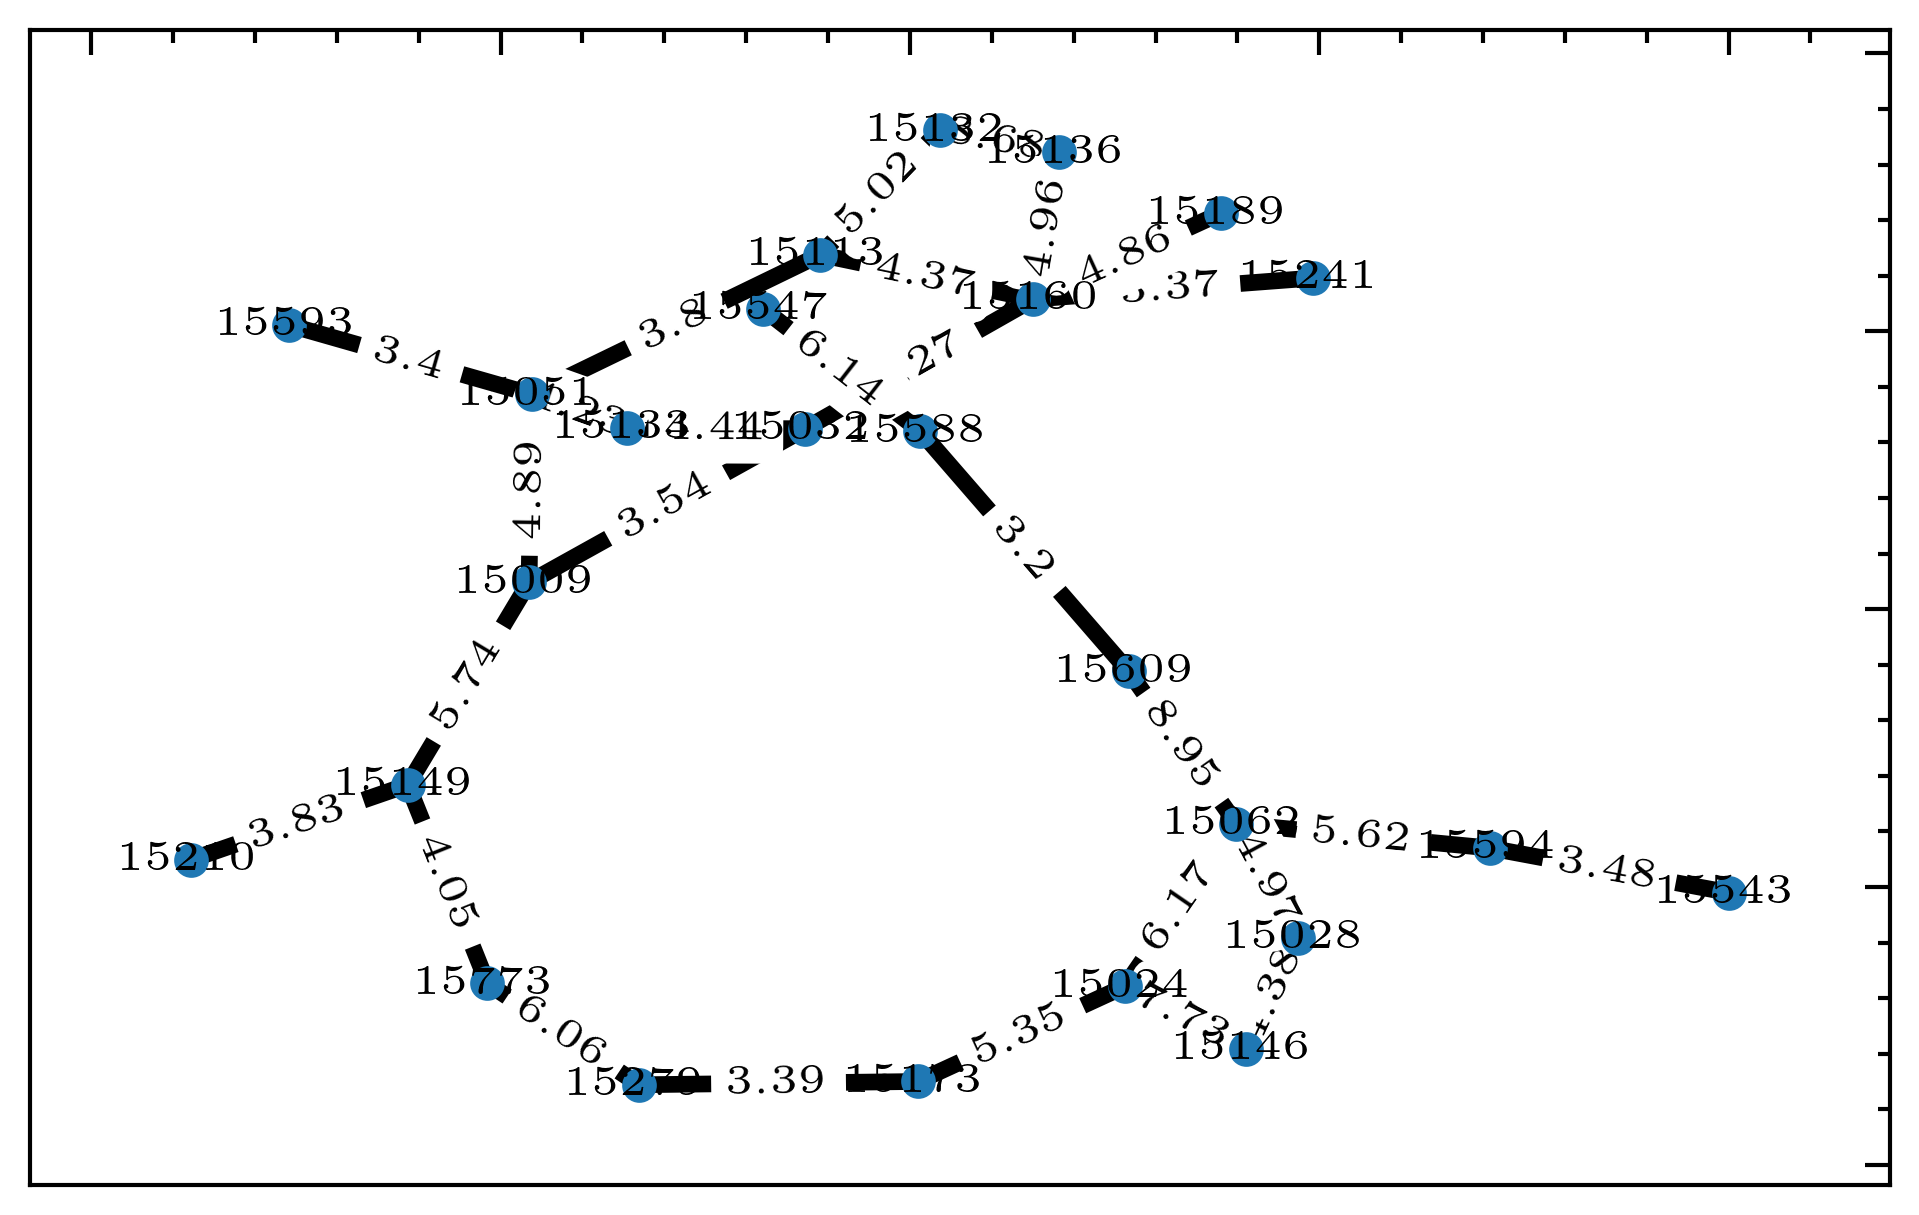

In [ ]:
from src.pipelines.association import get_graph_score

vehicle_id = 48

sb_graph = G.subgraph(cc[vehicle_id])
score = get_graph_score(sub_graph=sb_graph, edges=[], df=permute_df)

# plot the small graph
print(score)
plot_graph(vehicle_id, subgraph=sb_graph)

In [ ]:
score

[(231.9412133624253, 25)]

In [250]:
from src.pipelines.association import walk_graph_removals

removal_df = walk_graph_removals(
    sb_graph.copy(),
    cutoff=chi2.ppf(0.99, 4),
    max_removals=10,
    df=permute_df
)
# check if we can add any of the connections back and still satisfy the requirements?

removal_df.to_pandas()

remove_edges                                       graph_scores  \
0  [15062, 15594]  [[160.52164878127397, 23.0], [3.48479652404785...   
1  [15773, 15149]  [[30.006248074769974, 13.0], [88.7163059512774...   
2  [15062, 15609]  [[30.006248074769974, 13.0], [6.74997884035110...   
3  [15009, 15149]  [[12.018171838351659, 11.0], [6.74997884035110...   

   vehicle_index  
0              0  
1              0  
2              0  
3              0

5.575104927165168


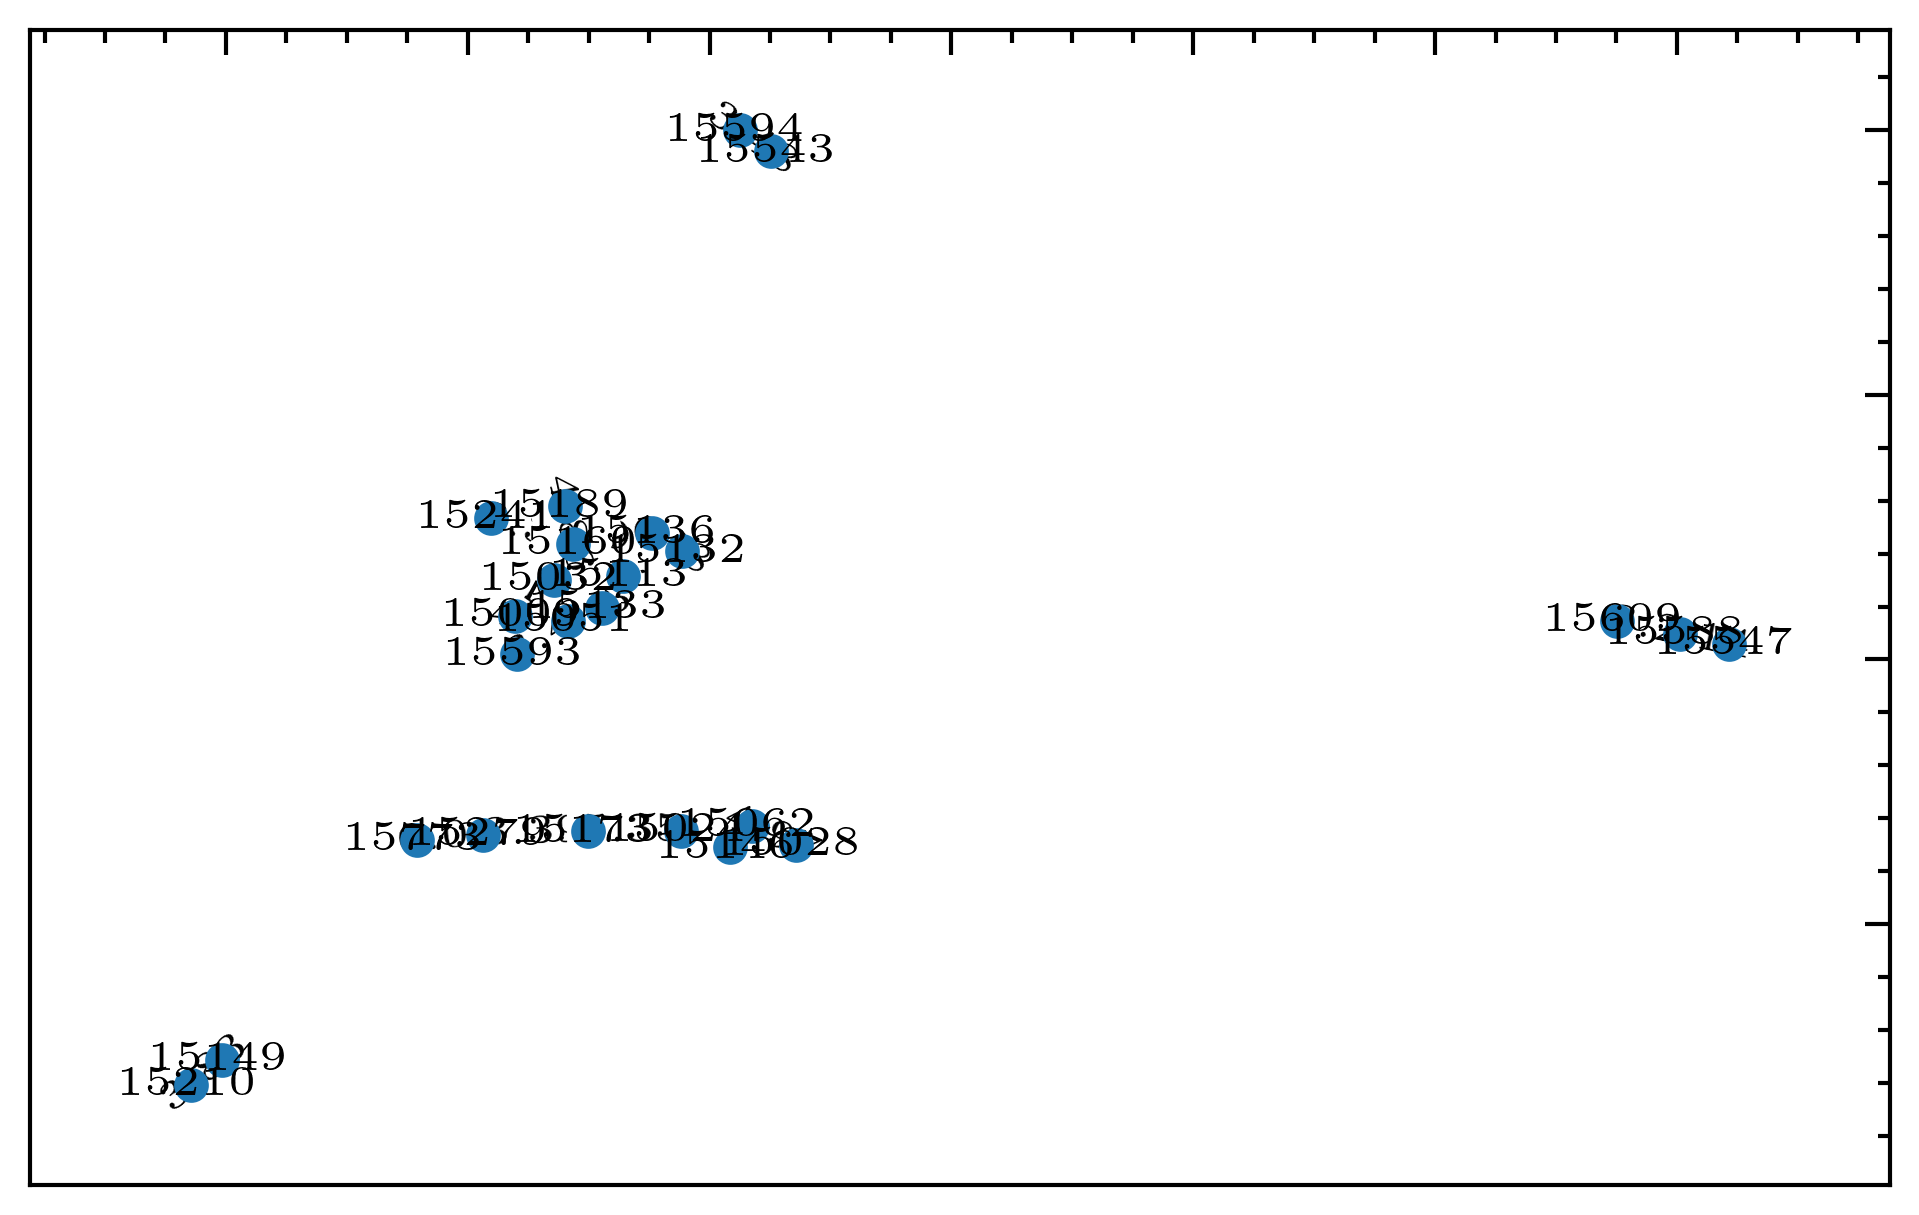

In [248]:
p_graph = G.subgraph(cc[vehicle_id]).copy()
for edge in removal_df['remove_edges']:
    p_graph.remove_edge(*edge)

score = get_graph_score(sub_graph=p_graph, edges=[], df=permute_df)
print(np.mean(score))
plot_graph(vehicle_id, subgraph=p_graph)

In [244]:
# p_graph = G.subgraph(cc[vehicle_id]).copy()
# for edge in removal_df['remove_edges'][1:]:
#     p_graph.remove_edge(*edge)

# score = get_graph_score(sub_graph=p_graph, edges=[], df=permute_df)
# print(np.mean(score))
# plot_graph(vehicle_id, subgraph=p_graph)

In [249]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta
from plotly.subplots import make_subplots

fig = go.Figure()

# vehicle_id = graph_scores

# 2023-03-12 21:42:21.100
cc_list = cc[vehicle_id]

# get a 10 minute window
plot_df = (
    joined_df.pipe(radar_obj.add_cst_timezone)
    .filter(
        pl.col("object_id").is_in(
            pl.Series(np.array(list(cc_list), dtype=np.int64), dtype=pl.Int64)
        )
    )
    .join(
        pl.DataFrame(
            [
                (i, v)
                for i, v_list in enumerate(list(nx.connected_components(p_graph)))
                for v in v_list
            ],
            schema=["vehicle_id_new", "object_id"],
        ).with_columns(pl.col("object_id").cast(pl.Int64)),
        on="object_id",
    )
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id_new",
    s_col="s",
    markers=True,
    fig=fig,
    # every=2,
)

fig.update_layout(yaxis_autorange="reversed")
# show the legend
fig.update_layout(showlegend=True)


fig.show()

function: add_cst_timezone took: 0.01885080337524414 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:40: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [226]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta
from plotly.subplots import make_subplots

fig = go.Figure()

vehicle_id = 48

# 2023-03-12 21:42:21.100
cc_list = cc[vehicle_id]

# get a 10 minute window
plot_df = (
    joined_df
    # .with_columns(pl.col("").alias("s"))
    .pipe(radar_obj.add_cst_timezone)
    # .sort("epoch_time_cst")
    .filter(
        pl.col("object_id").is_in(
            pl.Series(np.array(list(cc_list), dtype=np.int64), dtype=pl.Int64)
        )
    )
    # .with_columns(
    #     (pl.col("front_s").max() - pl.col("front_s")).alias("front_s"),
    # )
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="lane_index",
    s_col="s",
    markers=True,
    fig=fig,
    # every=2,
)

fig.update_layout(yaxis_autorange="reversed")

# add a plot of the d
other_fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="lane_index",
    s_col="d",
    markers=True,
    # fig=fig,
    # every=2,
)


fig.show()
other_fig.show()

function: add_cst_timezone took: 0.001817941665649414 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:40: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.

/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:40: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [ ]:
# ( assoc_df
#     # .with_columns(pl.col("").alias("s"))
#     .pipe(radar_obj.add_cst_timezone).sort('epoch_time_cst').filter(
#         pl.col("epoch_time_cst").is_between(
#             pl.lit("2023-03-13 11:48:54").str.strptime(
#                 pl.Datetime(time_unit="ns", time_zone="US/Central"),
#             ),
#             pl.lit("2023-03-13 11:50:00").str.strptime(
#                 pl.Datetime(time_unit="ns", time_zone="US/Central"),
#             ),
#         )
#         & (pl.col("lane").str.contains("E"))
#         & (pl.col("lane_index") == 0)
#         & (pl.col("prediction") )
#     ))

In [66]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


fig = go.Figure()

# 2023-03-12 21:42:21.100

# get a 10 minute window
plot_df = (
    assoc_df
    # .with_columns(pl.col("").alias("s"))
    .pipe(radar_obj.add_cst_timezone)
    # .sort("epoch_time_cst")
    .filter(
        pl.col("epoch_time_cst").is_between(
            pl.lit("2023-03-13 07:42:54").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
            pl.lit("2023-03-13 07:49:00").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
        )
        & (pl.col("lane").str.contains("E"))
        & (pl.col("lane_index") == 0)
    )
    # .with_columns(
    #     (pl.col("front_s").max() - pl.col("front_s")).alias("front_s"),
    # )
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
    fig=fig,
    # every=2,
)

fig.update_layout(yaxis_autorange="reversed")


fig.show()

function: add_cst_timezone took: 0.0021970272064208984 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:40: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [ ]:
# (
#     lf_df
#     .pipe(calculate_match_indexes, match_time_threshold=100)
#     .pipe(
#         pipe_gate_headway_calc, alpha=0.9
#     )
#     .collect()
# )

In [165]:
def build_intermediate() -> None:
    return (
        lf_df.pipe(calculate_match_indexes, match_time_threshold=100).pipe(
            pipe_gate_headway_calc, alpha=0.9
        )
        # .unnest("pair")
    )

In [170]:
# leader_id = 1343
# follower_id = 621


# keep_ids = assoc_df.filter(pl.col("vehicle_id").is_in([follower_id]))[
#     ["vehicle_id", "object_id"]
# ].unique()

# keep_follower_ids = keep_ids["object_id"].unique()
# keep_leader_ids = assoc_df.filter(pl.col("vehicle_id").is_in([leader_id]))[
#     "object_id"
# ].unique()

keep_follower_ids = [15062]
keep_leader_ids = [20580]


stats_df = (
    build_intermediate()
    .filter(
        # (
        #     pl.col("pair").list.get(0).is_in(keep_follower_ids)
        #     # & pl.col("pair").list.get(1).is_in(keep_leader_ids)
        # ) |  
        (
            pl.col("pair").list.get(0).is_in(keep_leader_ids)
            # & pl.col("pair").list.get(1).is_in(keep_follower_ids)
        )
    )
    .collect()
)

plot_df = lf_df.filter(
    (pl.col("object_id").is_in(keep_follower_ids) | pl.col("object_id").is_in(keep_leader_ids))
)

# plot the association_distance and s using plotly
from plotly.subplots import make_subplots

fig = make_subplots(
    # two y axis
    specs=[[{"secondary_y": True}]]
)

fig.add_trace(
    go.Scatter(
        x=plot_df["epoch_time"],
        y=plot_df["association_distance"],
        mode="lines+markers",
        name="Association Distance",
        line=dict(color="blue"),
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=plot_df["epoch_time"],
        y=plot_df["association_distance"].rolling_mean(10),
        mode="lines+markers",
        name="Association Distance - EWM",
        line=dict(color="purple"),
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=plot_df["epoch_time"],
        y=plot_df["front_s"],
        mode="lines+markers",
        name="s",
        line=dict(color="red"),
    ),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(
        x=plot_df["epoch_time"],
        y=plot_df["s_leader"],
        mode="lines+markers",
        name="s_leader",
        line=dict(color="green"),
    ),
    secondary_y=True,
)

function: lazy_func took: 0.0018889904022216797 seconds
function: lazy_func took: 0.0016679763793945312 seconds


In [ ]:
stats_df

## Fuse & Smooth the Trajectories


In [ ]:
# assoc_df.filter(
#     pl.col('vehicle_id').is_in([518, ])
# ).with_columns(
#     pl.count().over('epoch_time').alias('count')
# ).filter(
#     (pl.col('count') > 1)
# ).sort(
#     ['epoch_time', 'ip']
# ).with_c

In [ ]:
from src.pipelines.association import build_fusion_df

fusion_df = (
    assoc_df
    # .filter(
    #     pl.col('vehicle_id').is_in([518, 777])
    # )
    .pipe(build_fusion_df, prediction_length=prediction_length, max_vehicle_num=3)
    .collect(streaming=True)
    .pipe(
        radar_obj.add_cst_timezone,
        time_col="epoch_time",
    )
)
# fusion_df.head()

In [ ]:
# fusion_df.group_by(["vehicle_id", "time_index"]).agg(
#     pl.col("back_s").diff(),
#     pl.col("front_s").diff(),
#     pl.col("s").diff(),
# ).explode(["back_s", "front_s", "s"]).filter(pl.col("back_s").is_not_null())

In [ ]:
distance_adjuster = (
    fusion_df.group_by(
        [
            "vehicle_id",
            "time_index",
        ]
    )
    .agg(
        pl.col("distanceToFront_s")
        .filter(pl.col("approaching"))
        .mean()
        .alias("distanceToFront_s"),
        pl.col("distanceToBack_s")
        .filter(~pl.col("approaching"))
        .mean()
        .alias("distanceToBack_s"),
        pl.col("distanceToFront_s").mean().alias("distanceToFront_s_all"),
        pl.col("distanceToBack_s").mean().alias("distanceToBack_s_all"),
    )
    .with_columns(
        pl.when(pl.col("distanceToFront_s").is_null())
        .then(pl.col("distanceToFront_s_all"))
        .otherwise(pl.col("distanceToFront_s"))
        .alias("distanceToFront_s"),
        pl.when(pl.col("distanceToBack_s").is_null())
        .then(pl.col("distanceToBack_s_all"))
        .otherwise(pl.col("distanceToBack_s"))
        .alias("distanceToBack_s"),
    )
    .drop(["distanceToFront_s_all", "distanceToBack_s_all"])
)

In [ ]:
outer_df = (
    fusion_df.select(
        [
            "front_s",
            "s",
            "back_s",
            "s_velocity",
            "d",
            "d_velocity",
            "P",
            "vehicle_id",
            "time_index",
            "vehicle_time_index_int",
            "prediction",
            "length_s",
        ]
    )
    .lazy()
    .filter(~pl.col("prediction"))
)

outer_df = (
    (
        outer_df.join(
            outer_df,
            on=["time_index", "vehicle_id"],
            how="outer",
            suffix="_leader",
        )
    )
    .with_columns(
        pl.struct(
            [
                pl.min_horizontal(
                    [
                        pl.col("vehicle_time_index_int"),
                        pl.col("vehicle_time_index_int_leader"),
                    ]
                ).alias("one"),
                pl.max_horizontal(
                    [
                        pl.col("vehicle_time_index_int"),
                        pl.col("vehicle_time_index_int_leader"),
                    ]
                ).alias("two"),
            ]
        ).alias("vehicle_time_struct"),
    )
    # .collect()
    .filter(
        (
            pl.col("vehicle_time_index_int")
            .cum_count()
            .over(["vehicle_id", "time_index", "vehicle_time_struct"])
            < 1
        )
        & (pl.col("vehicle_time_index_int") != pl.col("vehicle_time_index_int_leader"))
    )
    .collect(streaming=True)
    .pipe(
        calc_assoc_liklihood_distance,
        gpu=GPU,
        dims=2,
    )
    .group_by(["vehicle_id", "time_index"])
    .agg(pl.col("association_distance").max())
)

In [ ]:
prediction_tracker = (
    fusion_df.select(
        [
            "vehicle_id",
            "time_index",
            # "vehicle_time_index_int",
            "prediction",
        ]
    )
    .lazy()
    .group_by(["vehicle_id", "time_index"])
    .agg(pl.col("prediction").all().alias("prediction"))
    .collect()
)

In [ ]:
# np.median(
#     fusion_df.filter(pl.col("P_CALC").arr.to_list().list.first().is_not_nan())["P_CALC"]
#     .to_numpy()
#     .reshape(-1, 6, 6),
#     axis=0,
# ).max()

In [ ]:
# fusion_df = (
#     fusion_df.lazy()
#     .join(
#         fusion_df.lazy()
#         .sort("epoch_time")
#         .filter(~pl.col('prediction'))
#         .group_by("vehicle_id")
#         .agg(pl.col("P_CALC").first().alias("last_P")),
#         on="vehicle_id",
#     )
#     .with_columns(pl.col(["last_P", "P_CALC"]).arr.to_list())
#     .with_columns(
#         pl.when(pl.col("prediction"))
#         .then(pl.col("last_P"))
#         .otherwise(pl.col("P_CALC"))
#         .alias("P_CALC")
#     )
#     .with_columns(pl.col("P_CALC").list.to_array(36))
#     .collect()
# )

In [ ]:
from src.filters.fusion import batch_join, rts_smooth

GPU = True

# errrrrr

# v = fusion_df["P"].to_numpy(writable=True)
# v[:, 0] += fusion_df["length_s"].to_numpy() / 4

# fusion_df = fusion_df.with_columns(
#     P=v,
# ).with_columns(pl.col("P").list.to_array(width=36))

merged_df = batch_join(
    fusion_df,
    method="ImprovedFastCI",
    batch_size=10_000 if not GPU else 8_000,
    gpu=GPU,
    s_col="front_s",
)

In [ ]:
merged_df = rts_smooth(
    merged_df, batch_size=10_000 if not GPU else 15_000, gpu=GPU, s_col="front_s"
)

In [ ]:
merged_df = (
    merged_df.lazy()
    .join(
        fusion_df.lazy()
        .select(["time_index", "vehicle_id", "object_id", "length_s"])
        .group_by(["time_index", "vehicle_id"])
        .agg(pl.col("object_id"), pl.col("length_s").mean()),
        on=["time_index", "vehicle_id"],
        how="left",
    )
    .join(
        outer_df.lazy().select(["time_index", "vehicle_id", "association_distance"]),
        on=["time_index", "vehicle_id"],
        how="left",
    )
    .join(
        distance_adjuster.lazy(),
        on=["vehicle_id", "time_index"],
        how="left",
    )
    .join(
        prediction_tracker.lazy(),
        on=["vehicle_id", "time_index"],
        how="left",
    )
    .with_columns(
        # (pl.col("ci_s") + pl.col("distanceToFront_s")).alias("ci_front_s"),
        # (pl.col("ci_s") + pl.col("distanceToBack_s")).alias("ci_back_s"),
        # (pl.col("s_smooth") + pl.col("distanceToFront_s")).alias("front_s_smooth"),
        # (pl.col("s_smooth") + pl.col("distanceToBack_s")).alias("back_s_smooth"),
        (pl.col("ci_front_s") - pl.col("length_s")).alias("ci_back_s"),
        (pl.col("ci_front_s") - pl.col("distanceToFront_s")).alias("ci_s"),
        (pl.col("front_s_smooth") - pl.col("length_s")).alias("back_s_smooth"),
        (pl.col("front_s_smooth") - pl.col("distanceToFront_s")).alias("s_smooth"),
    )
    .collect()
)

In [ ]:
# merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone).head()

In [ ]:
from src.plotting.single_veh import plot_vehicle

# 2370	22	2.326786	0.303536	"1"
# 1227	22	6.57618	1.667884	"1"
# 1209
vehs = [
    # 440
    # 4766,
    602,
    # 4791
    # 3845
    # 101,
    # 1098,
]

fig = None

for veh in vehs:
    ind_vehicles = (
        fusion_df.filter(pl.col("vehicle_id") == veh)["object_id"].unique().to_list()
    )

    fig = plot_vehicle(
        fusion_df.filter(pl.col("vehicle_id") == veh),
        s_velocity_col="s_velocity",
        s_col="front_s",
        fig=fig,
        data_name="IMM Filtered",
    )

    plot_vehicle(
        merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        # s_col="s_smooth",
        s_col="s_smooth",
        s_velocity_col="s_velocity_smooth",
        # s_velocity_col="ci_s_velocity",
        d_col="d_smooth",
        d_velocity_col="d_velocity_smooth",
        fig=fig,
        color="blue",
        data_name="Fused and Smoothed",
    )

    plot_vehicle(
        merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        # s_col="s_smooth",
        s_col="ci_s",
        s_velocity_col="ci_s_velocity",
        # s_velocity_col="ci_s_velocity",
        d_col="ci_d",
        d_velocity_col="ci_d_velocity",
        fig=fig,
        color="purple",
        data_name="CI Fused",
    )

    plot_vehicle(
        radar_df.filter(
            pl.col("object_id").is_in(
                assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
            )
            & ~pl.col("prediction")
        ).pipe(
            radar_obj.add_cst_timezone,
        ),
        # s_col="front_s",
        # s_velocity_col="s_velocity",
        d_col="d",
        # d_velocity_col="d_velocity",
        fig=fig,
        color="black",
        data_name="Radar Raw",
    )

    # add a plot of the position differentiated
    _diff_df = (
        radar_df.filter(
            pl.col("object_id").is_in(
                assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
            )
            & ~pl.col("prediction")
        )
        .pipe(
            radar_obj.add_cst_timezone,
        )
        .with_columns(
            (
                pl.col("s").diff()
                / (pl.col("epoch_time").diff().dt.total_milliseconds() / 1000)
            )
            .rolling_mean(center=True, window_size=50)
            .alias("diff_v")
        )
    )

    fig.add_trace(
        go.Scatter(
            x=_diff_df["epoch_time_cst"].cast(str),
            y=_diff_df["diff_v"],
            mode="lines",
            name="Radar Velocity",
            line=dict(color="black", width=2),
            yaxis="y2",
        )
    )


fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # update the subplot titles
    title_font_family="Times New Roman",
    title_font_size=44,
    # set the x_limit
    yaxis=dict(
        title="S Distance [m]",
    ),
    yaxis2=dict(
        title="S Velocity [m/s]",
    ),
    yaxis3=dict(
        title="D Distance [m/s]",
    ),
    yaxis4=dict(
        title="D Velocity [m/s]",
    ),
    # set the size of the figure
    width=1000,
    height=600,
    template="ggplot2",
    # set the margin to reduce the whitespace
    margin=dict(l=0, r=0, t=0, b=0),
    # put the legend on the bottom
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            # family="Times New Roman",
            size=22,
        ),
    ),
)

In [ ]:
import numpy as np
from scipy.signal import butter, sosfiltfilt
from scipy.integrate import cumtrapz


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype="low", analog=False, output="sos")
    return sos


sos = butter_lowpass(0.25, 1 / 0.1, order=5)


def butter_lowpass_filter(data, cutoff, fs, order=5):
    # normalize data
    # max_val = np.max(data)
    # data = data / max_val
    # b, a = butter_lowpass(cutoff, fs, order=order)
    return sosfiltfilt(
        sos,
        data,
    )


fig = plot_vehicle(
    fusion_df.filter(pl.col("vehicle_id") == veh),
    s_velocity_col="s_velocity",
    s_col="s",
    # fig=fig,
    data_name="IMM Filtered",
    show_d=False,
)


# add a plot of the position differentiated
_diff_df = (
    radar_df.filter(
        pl.col("object_id").is_in(
            assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
        )
        & ~pl.col("prediction")
    )
    .pipe(
        radar_obj.add_cst_timezone,
    )
    .sort("epoch_time")
    .with_columns(
        (
            (pl.col("utm_x").diff() ** 2 + pl.col("utm_y").diff() ** 2).sqrt()
            / (pl.col("epoch_time").diff().dt.total_milliseconds() / 1000)
        )
        .rolling_mean(center=True, window_size=10)
        .over("object_id")
        .alias("diff_v"),
        (
            pl.col("s").diff()
            / (pl.col("epoch_time").diff().dt.total_milliseconds() / 1000)
        )
        .rolling_mean(center=True, window_size=5)
        .over("object_id")
        .alias("diff_s_v"),
        (
            pl.col("s").diff()
            / (pl.col("epoch_time").diff().dt.total_milliseconds() / 1000)
        )
        .backward_fill(1)
        .map_elements(
            lambda x: pl.Series(
                values=butter_lowpass_filter(
                    x.to_numpy(), cutoff=0.25, fs=1 / 0.1, order=5
                ),
                name="diff_s_v_smooth",
            )
        )
        .over("object_id")
        .alias("diff_s_v_smooth"),
        (
            pl.col("s")
            .map_elements(
                lambda x: pl.Series(
                    values=butter_lowpass_filter(
                        x.to_numpy(), cutoff=0.25, fs=1 / 0.1, order=6
                    ),
                    # name="diff_s_v_smooth",
                )
            )
            .diff()
            / (pl.col("epoch_time").diff().dt.total_milliseconds() / 1000)
        )
        .over("object_id")
        .alias("diff_smooth_s_v"),
    )
    .with_columns(
        (
            pl.col("diff_s_v_smooth").map_elements(
                lambda x: pl.Series(
                    values=cumtrapz(x.to_numpy(), dx=0.1, initial=0),
                )
            )
            + pl.col("s").first()
        )
        .over("object_id")
        .alias("diff_s_v_smooth_int"),
    )
)


fig.add_trace(
    go.Scatter(
        x=_diff_df["epoch_time_cst"].cast(str),
        y=_diff_df["diff_v"],
        mode="lines",
        name="Radar Velocity",
        line=dict(color="black", width=2),
        yaxis="y2",
    )
)

fig.add_trace(
    go.Scatter(
        x=_diff_df["epoch_time_cst"].cast(str),
        y=_diff_df["diff_s_v"],
        mode="lines",
        name="Radar Velocity",
        line=dict(color="blue", width=2),
        yaxis="y2",
    )
)

fig.add_trace(
    go.Scatter(
        x=_diff_df["epoch_time_cst"].cast(str),
        y=_diff_df["diff_s_v_smooth"],
        mode="lines",
        name="Radar Velocity",
        line=dict(color="purple", width=2),
        yaxis="y2",
    )
)

fig.add_trace(
    go.Scatter(
        x=_diff_df["epoch_time_cst"].cast(str),
        y=_diff_df["diff_s_v_smooth_int"],
        mode="lines",
        name="Radar Velocity",
        line=dict(color="green", width=2),
        yaxis="y1",
    )
)

## Save the File


In [ ]:
from src.filters.vectorized_kalman import CALCFilter

print(CALCFilter.w_s)

In [ ]:
# add x/y as calculated by the Frenet Transform
transformations = [
    ("front_s_smooth", "d_smooth", "front_x_smooth", "front_y_smooth"),
    ("back_s_smooth", "d_smooth", "back_x_smooth", "back_y_smooth"),
    ("s_smooth", "d_smooth", "centroid_x_smooth", "centroid_y_smooth"),
    ("ci_front_s", "ci_d", "ci_front_x", "ci_front_y"),
    ("ci_back_s", "ci_d", "ci_back_x", "ci_back_y"),
    ("ci_s", "ci_d", "ci_centroid_x", "ci_centroid_y"),
]

for s_col, d_col, x_col, y_col in transformations:
    merged_df = (
        merged_df.pipe(
            mainline_net.frenet2xy,
            lane_col="lane",
            s_col=s_col,
            d_col=d_col,
        )
        .drop(["s", "angle"])
        .rename({"x_lane": x_col, "y_lane": y_col})
    )